### Numerical Stability of FastSurferCNN/VINN Segmentation Pipeline using Verrou
COMP490 - Project Report<br>
Park, Hae Lang (40107608)<br>
2023-06-28

### <b>1. Introduction </b>

The project aims to evaluate the numerical uncertainty of <i>FastSurfer</i> software, especially its <b>whole-brain segmentation pipeline</b>. FastSurfer uses deep-learning models – <b>Convolutional Neural Network (CNN)</b> and <b>Voxel-size Independent Neural Networks (VINN)</b> – to compute volumetric segmentation of the brain from MRI images. To assess the numerical uncertainty of the FastSurfer’s segmentation model, its standard performance will be compared to its performance after a random noise has been introduced into the model. To introduce this noise, Verrou, a Valgrind-based tool will be used. Verrou provides tools for the numerical analysis of floating-point computations within a program, using rigorous mathematical techniques to quantify the numerical uncertainty of the computations. The project will mainly use its float-point random rounding operations to reduce the precision of the segmentation model’s computations. The impact of reduced precision on the performance of FastSurfer’s segmentation pipeline will be used to provide insights into the deep-learning model’s reliability and its limitations if any.


### <b> 1.1 FastSurferCNN/VINN </b>
FastSurferCNN is the first part of the FastSurfer neuroimaging pipeline that segments the whole brain image into 95 classes in under 1 minute when executed on the GPU [2]. This pipeline is composed of three convolutional neural networks, each performing inference on a distinct orientation of the brain image: coronal, sagittal and axial views. <br>
<figure>
<img src="https://ars.els-cdn.com/content/image/1-s2.0-S1053811920304985-gr2_lrg.jpg">
<figcaption align = "center"> Fig.1. FastSurfer Convolutional Neural Network Architecture </figcaption>
</figure>
<br>
Each of the three FastSurfer's CNNs is a UNet-type network with a series of four competitive dense blocks (CDB) in the encoder and decoder arm separated by a CDB bottleneck layer [2]. Except for the first CDB, all blocks are composed of three sequences of operations: parametric rectified linear unit (PReLU), convolution (Conv), and batch normalization (BN) [2]. To normalize the raw inputs fed to the network, the first block’s PReLU step is replaced with BN [2].
<br>
FastSurferCNN was trained with MRI volumes from the selected 140 subjects from  the following publicly available datasets [2]:

- Autism Brain Imaging Data Exchange II (ABIDE II) 
- the Alzheimer’s Disease Neuroimaging Initiative (ADNI) 
- the UCLA Consortium for Neuropsychiatric Phenomics LA5c Study (LA5c)
- the Open Access Series of Imaging Studies 1 and 2 (OASIS-1 and OASIS-2)
<br>

There were a few limitations with the CNN neuroimaging model, namely the problem of availability and diversity within the input subjects and the non-uniformity in the resolutions of input images [3]. As CNN models highly rely on the resolutions of input images used during training, it is difficult to apply the models outside the traditional 1.0 mm MRI scans available for studies. In addition, with improvements in imaging technology, MRIs with higher submillimeter resolutions capturing more details are made available for studies. As these HiRes MRIs become more popular within the neuroimaging community, it is not difficult to predict the shift towards better resolution in the current and future studies [3]. To extend the model’s applicability to resolutions not explicitly included in the training dataset, the software transitioned into Voxel-size Independent Neural Networks (VINN) to achieve resolution independence, by allowing flexible transitions between resolutions [3].
<br>
<figure>
<img src="https://ars.els-cdn.com/content/image/1-s2.0-S1053811922000623-gr3_lrg.jpg">
<figcaption align = "center"> Fig.2. FastSurfer Voxel-size Independent Neural Network Architecture </figcaption>
</figure>
<br>
FastSurferVINN integrates resolution-normalization within the network with the additional encoder and decoder layers added before and after the four CDBs used in FastSurferCNN. These additional layers allow variable transitions between different image resolutions through a flexible interpolation step [3]. In addition, unlike FastSurferCNN, in FastSurferVINN, each CDB is composed of four sequences of operations: PReLU, Conv, and BN [3]. Similar to the first CDB of the FastSurferCNN, BN was used instead of PReLU in both encoder blocks (pre-IDB and IDB) of the FastSurferVINN [3]. 
<br>
FastSurferVINN was trained on selected 120 subjects from the following publicly available datasets [3]: 

- ABIDE-II
- the Human Connectome Project Young Adult (HCP), 
- the Rhineland Study dataset, LA5C
- Minimal Interval Resonance Imaging in Alzheimer’s Disease dataset (MIRIAD), and 
- OASIS-1 and OASIS-2

The voxel resolutions varied between the selected datasets, with the input image being in the resolution of 0.7mm, 0.8mm or 1.0mm.


A pre-trained FastSurferCNN/VINN is currently available in the __[open-source FastSurfer package](https://github.com/deep-mi/FastSurfer)__. The version 2.1.0 is used for this project.

### <b> 1.2 Verrou </b>

Verrou is a Valgrind-based tool that uses Monte Carlo Arithmetic (MCA) to verify the floating-point accuracy in numeric operations of programs. By implementing stochastic floating-point arithmetic grounded in the principle of random rounding, Verrou perturbs all floating-point operations performed by a given program. This perturbation manifests through the random alternation of rounding modes during each floating-point operations [4]. The utilization of Verrou presents a notable advantage as it facilitates a straightforward evaluation of round-off errors in floating-point calculations without necessitating program recompilation. With a simple modification in the command line as seen below, the assessment of floating-point precision can be seamlessly integrated.

```valgrind --tool=verrou --rounding-mode=random {program} [program options]```


For the purpose of this project, Verrou version 3.21.0 is employed. The detailed method of execution is found in the __[official documentation](https://github.com/edf-hpc/verrou)__. 

#### Implementation of Monte Carlo Arithmetic approach

As previously mentioned, Verrou implements the Monte Carlo Arithmetic (MCA) approach using the Valgrind tool system to assess the floating-point accuracy in numerical computations. Monte Carlo Arithmetic (MCA) transforms any set of program execution into a sample of a random variable represented by the result of the operation and its floating-point accuracy [1].
<br>For any binary operator \*, this can be represented as: 

```
x * y = round(x * y) + δ,
```

where <i>round(x * y)</i> represents the rounded result of the binary operation, and <i>δ</i> represents the exact floating-point value computed with the standard approach [1]. Depending on the sign of δ, the exact result of the operation is subject to either upward or downward rounding. Verrou’s random rounding mode used in the project is a strategy that returns the upwards and downward rounding of the result randomly, with equiprobability [1].

### <b> 2. Methodology</b>
#### <b> 2.1 Dataset </b>

The raw input data is taken from the __[Consortium for Reliability and Reproducibility (CoRR)](http://fcon_1000.projects.nitrc.org/indi/CoRR/html/samples.html)__ dataset available through __[Datalad](http://datasets.datalad.org/?dir=/corr/RawDataBIDS)__. CoRR contains 35 distinct datasets from universities, hospitals, and scientific institutions from different countries. An anatomical scan of one subject from each of the 32 datasets has been added to the dataset used for the project. Thus, the final dataset contain 35 distinct T1 MRI brain images in Neuroimaging Informatics Technology Initiative (NIfTI) format coming from subjects of different ages and ethnicities.

#### <b>2.2 Executing FastSurferCNN</b>
#### a. Docker

FastSurfer's segmentation pipeline can be executed using Docker by pulling the official Docker image published by the authors through the Dockerhub. This method avoids installation of the FastSurfer software, facilitating the brain segmentation execution on local machines. 
Comprehensive guidelines and instructions on the configuration and the execution of the segmentation pipeline through a Docker container is available in the official __[open-source repository](https://github.com/Deep-MI/FastSurfer/tree/stable/Docker)__. 

As a preliminary assessment, a heuristic validation was conducted employing the input file provided in the official __[tutorial](https://colab.research.google.com/github/Deep-MI/FastSurfer/blob/master/Tutorial/Tutorial_FastSurferCNN_QuickSeg.ipynb?authuser=0&pli=1#scrollTo=U8GLWgmfViFV)__ made available through Google Colab. The segmentation result was then juxtaposed with the original input image for an enhanced visualization of the brain segmentation.The following python code for visualization was provided in the official tutorial.


In [1]:
#import required libraries
%matplotlib inline
import nibabel as nib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from skimage import color
import torch
import numpy as np
from torchvision import utils

#define function to plot output
def plot_predictions(image, pred):
    """
    Function to plot predictions from validation set.
    :param images_batch:
    :param labels_batch:
    :param batch_output:
    :param plt_title:
    :param file_save_name:
    :return:
    """

    f = plt.figure(figsize=(20, 20))
    n, h, w = image.shape

    mid_slice = n // 2
    image = torch.from_numpy(np.expand_dims(image[mid_slice+16:mid_slice+32, :, :], 1))
    grid = utils.make_grid(image, nrow=4)

    plt.subplot(311)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Slices')

    grid2 = utils.make_grid(torch.from_numpy(np.expand_dims(pred[mid_slice+16:mid_slice+32, ...], 1)), nrow=4)[0]
    color_grid = color.label2rgb(grid2.numpy(), bg_label=0)
    plt.subplot(312)
    plt.imshow(color_grid)
    plt.title('Prediction')

    plt.subplot(313)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.imshow(color_grid, alpha=0.3)
    plt.title('Overlay_GT')

    for ax in f.axes:
      ax.grid(b=None)
      ax.axis("off")
    plt.tight_layout()

    plt.show()


C:\Users\phael\AppData\Local\Temp\ipykernel_19792\3777706523.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
c:\Users\phael\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


C:\Users\phael\AppData\Local\Temp\ipykernel_19792\3777706523.py:46: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


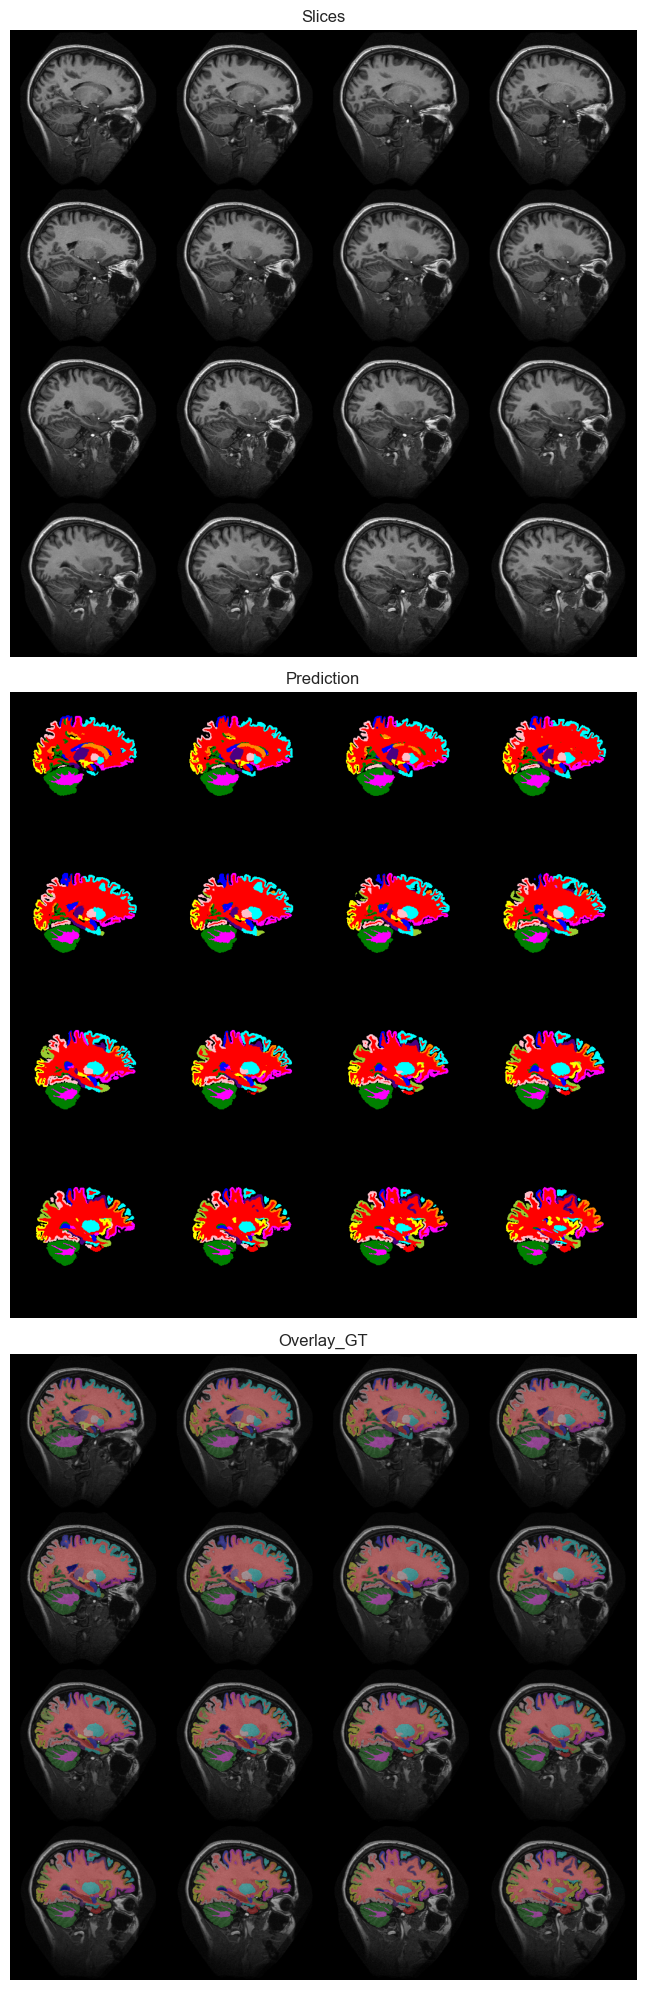

In [2]:
#load original MRI for visualization
orig_data = nib.load('./images/140_orig.mgz').get_fdata() / 255

#load output data
pred_data = nib.load('./images/140_output_docker.mgz').get_fdata()

plot_predictions(orig_data, pred_data)

#### b. Singularity

FastSurfer's segmentation pipeline can also be executed with Singularity. FastSurfer's Singularity image can be generated directly from the official Docker image provided by the authors. The conversion process between the Docker and Singularity is completed with the open-source docker image known as  __[docker2singularity](https://github.com/singularityhub/docker2singularity)__. Comprehensive instructions on how to use the conversion software are available in the public GitHub repository.<br>

Similar to its Docker counterpart, the authors of FastSurfer software provided detailed guidelines on how to configure the brain segmentation pipeline through Singularity in the official open-source repository's __[Singularity](https://github.com/Deep-MI/FastSurfer/tree/stable/Singularity)__ section.<br>

Once the conversion is complete, the following command line was used to limit the FastSurfer software's execution to the segmentation pipeline only, as the surface reconstruction pipeline of FastSurfer is out of the project's scope.
<br>

```
singularity exec --nv -B /home/user/my_mri_data:/data \
                      -B /home/user/my_fastsurfer_analysis:/output \
                       /home/user/fastsurfer-latest.sif \
                       /fastsurfer/run_fastsurfer.sh \
                      --t1 /data/subjectX/orig.mgz \
                      --sid subjectX \
                      --sd /output \
                      --seg_only \
                      --parallel \
                      --device cpu
```

<br>
From the above command line:
<li><i>/home/user/my_mri_data</i> is replaced with the path of the directory containing the input data files
<li><i>/home/user/my_fastsurfer_analysis</i> is replaced with the path of the directory where segmentation output files will be saved
<li><i>/home/user/fastsurfer-latest.sif</i> is replaced with the path of the singularity image file
<li><i>/subjectX/orig.mgz</i> is replaced with the path to the input file 
<li><i>subjectX</i> is replaced with the subject's ID

As before, heuristic validation was executed with the input file from the official tutorial with the configuration for the singularity image. Below is the output of execution with the example input MRI file made available in the official FastSurfer tutorial.


C:\Users\phael\AppData\Local\Temp\ipykernel_19792\3777706523.py:46: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


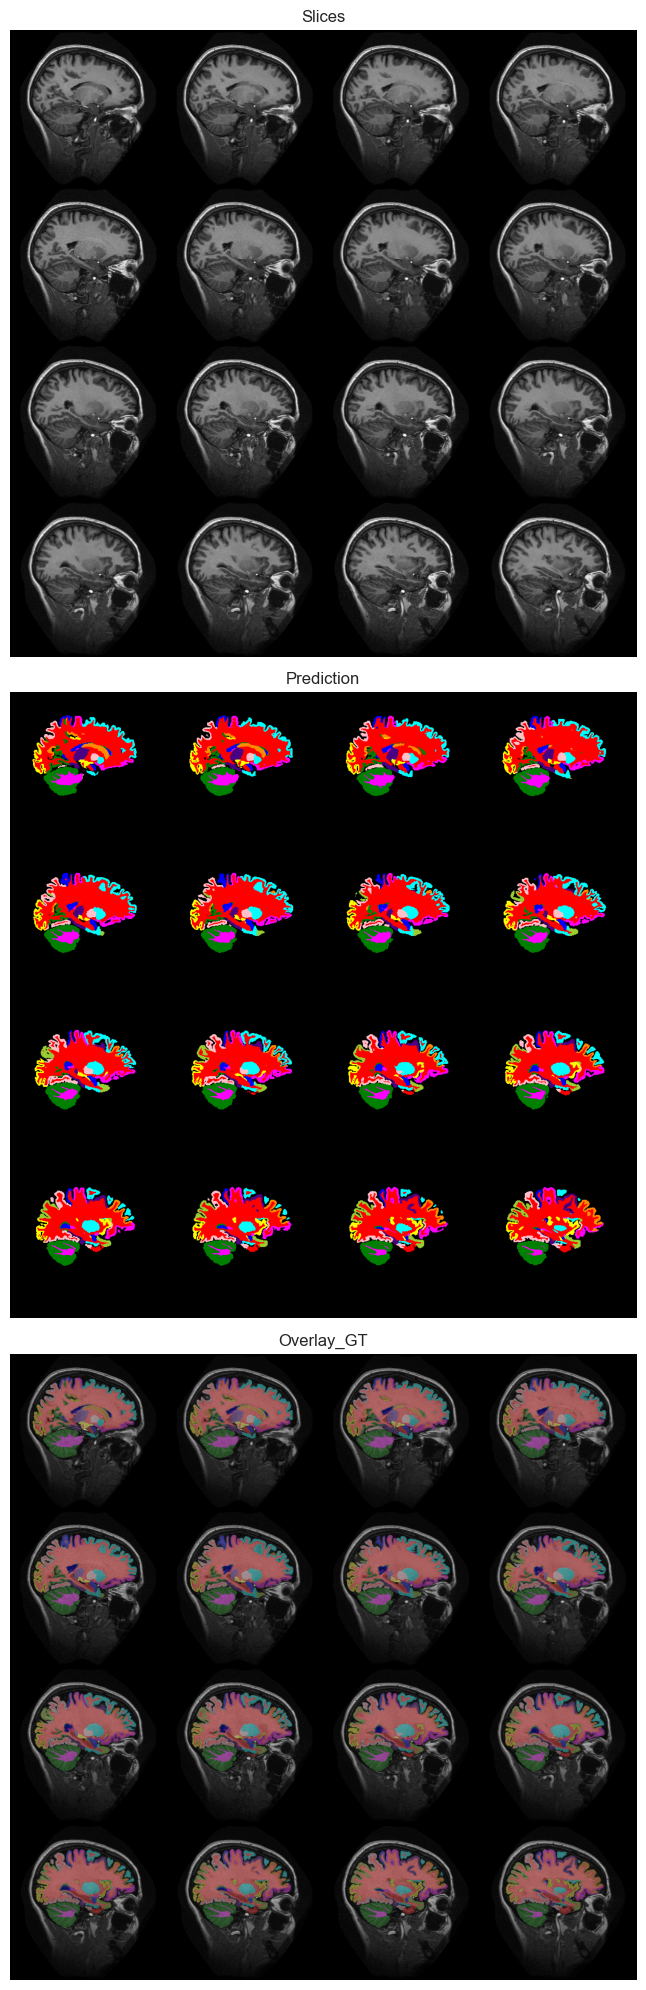

In [3]:
#load original MRI and output for visualization
orig_data = nib.load('./images/140_orig.mgz').get_fdata() / 255
pred_data = nib.load('./images/140_output_singularity.mgz').get_fdata()
plot_predictions(orig_data, pred_data)

#### <b> 2.3 Executing Verrou </b>

To better understand how to execute Verrou software, a Docker image is built from the following Dockerfile. The content of the Dockerfile is based on the instructions provided in the official __[open-source library](https://github.com/edf-hpc/verrou)__.

```Dockerfile
#Base
FROM ubuntu:20.04

#Dependencies
RUN apt-get update && apt-get install -y\
    build-essential\
    git\
    automake\
    python3\
    libc6-dbg

#Make directory 
RUN mkdir /build

#Clone verrou repository
WORKDIR /build

RUN git clone --branch=VALGRIND_3_21_0 --single-branch git://sourceware.org/git/valgrind.git valgrind-3.21.0+verrou-dev

WORKDIR /build/valgrind-3.21.0+verrou-dev
RUN git clone https://github.com/edf-hpc/verrou.git verrou 
RUN patch -p1 <verrou/valgrind.diff

#Configure valgrind
RUN ./autogen.sh
RUN ./configure --enable-only64bit --enable-verrou-fma --prefix=/build/opt/valgrind-3.21.0+verrou-dev

#build and install
RUN make
RUN make install

#load the environment
WORKDIR /build/opt/valgrind-3.21.0+verrou-dev
RUN . /build/opt/valgrind-3.21.0+verrou-dev/env.sh
```
<br>
After building the Docker image from this Dockerfile, a Docker container is executed to verify the configuration of the software. Following paragraph represents the result of floating-point rounding error verification using Python3's numerical operation.<br>
To begin, launching Verrou ouputs the following header.

```
valgrind --tool=verrou --rounding-mode=random python3
==20== Verrou, Check floating-point rounding errors
==20== Copyright (C) 2014-2019, EDF (F. Fevotte & B. Lathuiliere). 2019-2023, EDF (B. Lathuiliere). 2020-2021, TriScale innov (F. Fevotte)
==20==  
==20== Using Valgrind-3.21.0.verrou-dev and LibVEX; rerun with -h for copyright info
==20== Command: python3
==20== 
==20== First seed : 27199
==20== Backend verrou : 1.x-dev
==20== Backend mcaquad : 1.x-dev
==20== Backend checkcancellation : 1.x-dev
==20== Backend check_float_max : 1.x-dev
==20== Backend checkdenorm : 1.x-dev
==20== Instrumented operations :
==20==  add : yes
==20==  sub : yes
==20==  mul : yes
==20==  div : yes
==20==  mAdd : yes
==20==  mSub : yes
==20==  sqrt : yes
==20==  cmp : no
==20==  conv : yes
==20==  max : no
==20==  min : no
==20== Instrumented vectorized operations :
==20==  scal : no
==20==  llo  : yes
==20==  vec2  : yes
==20==  vec4  : yes
==20==  vec8  : yes
==20==  unk  : yes
==20== Instrumented type :
==20==  flt : yes
==20==  dbl : yes
==20== Backend verrou simulating RANDOM rounding mode
Python 3.8.10 (default, Mar 13 2023, 10:26:41) 
[GCC 9.4.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
```

As floating-point operation is constantly perturbed, each execution of the <i>sum()</i> function results in slightly different floating-point value.<br>
```
>>> sum([0.1*i for i in range(15)])
10.5
>>> sum([0.1*i for i in range(15)])
10.500000000000002
>>> sum([0.1*i for i in range(15)])
10.5
>>> sum([0.1*i for i in range(15)])
10.499999999999998
>>> sum([0.1*i for i in range(15)])
10.500000000000002
>>> sum([0.1*i for i in range(15)])
10.499999999999996
>>> exit()
```
Once the program is terminated the summary of operations is printed as below.
```
==20== 
==20==  ---------------------------------------------------------------------
==20==  Operation                            Instruction count
==20==   `- Precision
==20==       `- Vectorization          Total             Instrumented
==20==  ---------------------------------------------------------------------
==20==  add                      432                      432          (100%)
==20==   `- dbl                      432                      432      (100%)
==20==       `- llo                      432                      432  (100%)
==20==  ---------------------------------------------------------------------
==20==  sub                      126                      126          (100%)
==20==   `- dbl                      126                      126      (100%)
==20==       `- llo                      126                      126  (100%)
==20==  ---------------------------------------------------------------------
==20==  mul                      552                      552          (100%)
==20==   `- dbl                      552                      552      (100%)
==20==       `- llo                      552                      552  (100%)
==20==  ---------------------------------------------------------------------
==20==  div                        7                        7          (100%)
==20==   `- dbl                        7                        7      (100%)
==20==       `- llo                        7                        7  (100%)
==20==  ---------------------------------------------------------------------
==20==  cmp                      719                        0          (  0%)
==20==   `- dbl                      719                        0      (  0%)
==20==       `- scal                     719                        0  (  0%)
==20==  ---------------------------------------------------------------------
==20==  conv                     142                        0          (  0%)
==20==   `- dbl=>int                 136                        0      (  0%)
==20==       `- scal                     136                        0  (  0%)
==20==   `- dbl=>sht                   6                        0      (  0%)
==20==       `- scal                       6                        0  (  0%)
==20==  ---------------------------------------------------------------------
==20==  min                        1                        0          (  0%)
==20==   `- dbl                        1                        0      (  0%)
==20==       `- llo                        1                        0  (  0%)
==20==  ---------------------------------------------------------------------
==20== For lists of detected and suppressed errors, rerun with: -s
==20== ERROR SUMMARY: 0 errors from 0 contexts (suppressed: 0 from 0)
```



#### <b> 2.4 Executing FastSurfer Segmentation wiht Verrou</b>
Now that we familiarized ourselves with the Verrou software and gained proficiency in its operation, we can now incorporate Verrou's float-point rounding techniques into FastSurfer's neural networks. First, a new Docker image is needed to combine both Verrou and FastSurfer environments into a single container. To achieve this, I used a multi-stage build, integrating the Verrou environment set in the previous step into the FastSurfer's open-source environment published by the authors. <br>
For some operations, repeated calculations with Verrou's random rounding can produce significantly deviant results from the expected interval. Perturbation with random rounding often leads to an abundance of false positive results, which requires a cautious approach when introducing Verrou into the studied operations. To mitigate this problem, it is recommended to temporarily disable the perturbations during the execution of the functions known to yield erroneous results that can disturb the completion of the whole computing program. It is why Interlibmath module was introduced in the final Verrou environment built for the experiment.

```Dockerfile
FROM deepmi/fastsurfer:latest

#Dependencies
RUN apt-get update && apt-get install -y\
    build-essential\
    git\
    automake\
    python3\
    libc6-dbg

#CLone verrou repository
RUN cd /home && git clone --branch=VALGRIND_3_21_0 --single-branch git://sourceware.org/git/valgrind.git valgrind-3.21.0+verrou-dev

WORKDIR /home/valgrind-3.21.0+verrou-dev 
RUN git clone https://github.com/edf-hpc/verrou.git verrou && patch -p1 <verrou/valgrind.diff

#Configure and build
WORKDIR /home/valgrind-3.21.0+verrou-dev 
RUN mkdir build && ./autogen.sh && ./configure --enable-only64bit --enable-verrou-fma --prefix=/home/valgrind-3.21.0+verrou-dev/build && make && make install

#Configure Interlibmath 
WORKDIR /home/valgrind-3.21.0+verrou-dev/verrou/Interlibmath
RUN make
WORKDIR /home/valgrind-3.21.0+verrou-dev/verrou/synchroLib 
RUN make

#run env.sh
WORKDIR /home/valgrind-3.21.0+verrou-dev 
CMD source /home/valgrind-3.21.0+verrou-dev/build/env.sh
ENV PATH=/home/valgrind-3.21.0+verrou-dev/build/bin:${PATH}
ENV PYTHON_PREFIX=/home/valgrind-3.21.0+verrou-dev/build
ENV PYTHONPATH=/home/valgrind-3.21.0+verrou-dev/build/lib/python3.8/site-packages:${PYTHONPATH}
ENV MANPATH=/home/valgrind-3.21.0+verrou-dev/build/share/man:${MANPATH}
ENV CPATH=/home/valgrind-3.21.0+verrou-dev/build/include:${CPATH}
ENV VERROU_COMPILED_WITH_FMA=yes
ENV VERROU_COMPILED_WITH_QUAD=yes

ENTRYPOINT [ "/bin/bash" ]
```
<br>
To ensure the successful integration of Verrou with FastSurfer, I performed the same operation used to verify the successful build of the Verrou's standalone environment. As shown in the results below, the Verrou environment was successfully built within the FastSurfer environment, and the container is now ready to execute the brain segmentation with Verrou's float-point rounding operations.

```
valgrind --tool=verrou --rounding-mode=random python3
==17== Verrou, Check floating-point rounding errors
==17== Copyright (C) 2014-2019, EDF (F. Fevotte & B. Lathuiliere). 2019-2023, EDF (B. Lathuiliere). 2020-2021, TriScale innov (F. Fevotte)
==17==
==17== Using Valgrind-3.21.0.verrou-dev and LibVEX; rerun with -h for copyright info
==17== Command: python3
==17==
==17== First seed : 555498
==17== Backend verrou : 1.x-dev
==17== Backend mcaquad : 1.x-dev
==17== Backend checkcancellation : 1.x-dev
==17== Backend check_float_max : 1.x-dev
==17== Backend checkdenorm : 1.x-dev
==17== Instrumented operations :
==17==  add : yes
==17==  sub : yes
==17==  mul : yes
==17==  div : yes
==17==  mAdd : yes
==17==  mSub : yes
==17==  sqrt : yes
==17==  cmp : no
==17==  conv : yes
==17==  max : no
==17==  min : no
==17== Instrumented vectorized operations :
==17==  scal : no
==17==  llo  : yes
==17==  vec2  : yes
==17==  vec4  : yes
==17==  vec8  : yes
==17==  unk  : yes
==17== Instrumented type :
==17==  flt : yes
==17==  dbl : yes
==17== Backend verrou simulating RANDOM rounding mode
Python 3.8.16 (default, Mar  2 2023, 03:21:46)
[GCC 11.2.0] :: Anaconda, Inc. on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> sum([0.1*i for i in range(15)])
10.500000000000002
>>> sum([0.1*i for i in range(15)])
10.5
>>> sum([0.1*i for i in range(15)])
10.500000000000002
>>> sum([0.1*i for i in range(15)])
10.500000000000002
>>> sum([0.1*i for i in range(15)])
10.5
>>> sum([0.1*i for i in range(15)])
10.499999999999998
>>> exit()
==17==
==17==  ---------------------------------------------------------------------
==17==  Operation                            Instruction count
==17==   `- Precision
==17==       `- Vectorization          Total             Instrumented
==17==  ---------------------------------------------------------------------
==17==  add                      720                      720          (100%)
==17==   `- dbl                      720                      720      (100%)
==17==       `- llo                      720                      720  (100%)
==17==  ---------------------------------------------------------------------
==17==  sub                      126                      126          (100%)
==17==   `- dbl                      126                      126      (100%)
==17==       `- llo                      126                      126  (100%)
==17==  ---------------------------------------------------------------------
==17==  mul                      840                      840          (100%)
==17==   `- dbl                      840                      840      (100%)
==17==       `- llo                      840                      840  (100%)
==17==  ---------------------------------------------------------------------
==17==  div                       11                       11          (100%)
==17==   `- dbl                       11                       11      (100%)
==17==       `- llo                       11                       11  (100%)
==17==  ---------------------------------------------------------------------
==17==  cmp                      655                        0          (  0%)
==17==   `- dbl                      655                        0      (  0%)
==17==       `- scal                     655                        0  (  0%)
==17==  ---------------------------------------------------------------------
==17==  conv                     155                        0          (  0%)
==17==   `- dbl=>int                 149                        0      (  0%)
==17==       `- scal                     149                        0  (  0%)
==17==   `- dbl=>sht                   6                        0      (  0%)
==17==       `- scal                       6                        0  (  0%)
==17==  ---------------------------------------------------------------------
==17==  min                        1                        0          (  0%)
==17==   `- dbl                        1                        0      (  0%)
==17==       `- llo                        1                        0  (  0%)
==17==  ---------------------------------------------------------------------
==17== For lists of detected and suppressed errors, rerun with: -s
==17== ERROR SUMMARY: 0 errors from 0 contexts (suppressed: 0 from 0)
```
Considering that the segmentation process will be carried out on clusters, it was necessary to convert the Docker image into a Singularity image for a seamless execution of the segmentation on the designated clusters. The conversion is done with <b>docker2singularity</b> Docker image introduced in section 2.2. 


#### <b>2.5 Sørensen-Dice Coefficient</b>
The evaluation metric used for this expeirment is the Sørensen-Dice Coefficient (SDC). Also known as Dice Similarity Coefficient, SDC is a statistical measure used to quantify the similarity between two samples. This measure is used in various fields, including image segmentation, pattern recognition, and information retrieval. SDC is defined as twice the number of common elements between the two sets divided by the sum of their sizes. For given two sets A and B, SDC can be represented as follows:
```
SDC = 2*|(A ⋂ B)| / |(A ⋃ B)|
```
The Sørensen-Dice Coefficient ranges between 0 and 1, with 0 indicating no similarity between two sets, and 1 representing a perfect similarity or a complete overlap between two sets. In the image segmentation evaluation, SDC provides a quantitative assessment of how well the predicted segmentation aligns with the ground truth, with values closer to 1 indicating better accuracy.



### <b>3. Experiment and Results</b>

#### <b>3.1 Experiment </b>
Planned maintenance made the computing nodes on Narval clusters unavailable for some days. Due to limitations in time, the final experiment was executed on the computer cluster owned and administrated by Concordia University's Big Data Infrastructures for Neuroinformatics Lab.<br>
Slurm open-source cluster work management system is used to launch the execution of FastSurfer segmentation with Verrou on the lab cluster.
The minimum requirement to successfully execute the standard FastSurfer segmentation with IEEE rounding operations is 8GB of CPU memory. 

During the testing phase, the segmentation of a single subject employing Verrou's float-point rounding operations demonstrated an average processing speed of over 1900 seconds per batch for each of the three inference steps. FastSurfer's segmentation procedure entails sequential inference on three neural networks — coronal, sagittal, and axial —, each comprising 256 batches. Consequently, the total execution time for segmenting a single subject's brain image could be estimated to around 400 hours and above.

To complete the execution in timely a manner, __[job array feature](https://slurm.schedmd.com/job_array.html)__ of Slurm was used to execute the segmentation across the 35 subjects in parallel. Considering limitations in time and memory capacity, only four iterations could be concurrently executed on each of the 35 subjects, utilizing the entirety of the available resources within the cluster. 

```shell script
#!/bin/bash
#SBATCH --job-name=fsv-35_1
#SBATCH --mem-per-cpu=8G
#SBATCH --array=0-34
#SBATCH --time=UNLIMITED
#SBATCH --partition=cpu,gpu
#SBATCH --output=path_to_directory_where_outfiles_is_stored/%A_%a.out
​
# Set the path to Singularity image
SINGULARITY_IMAGE="path to singularity image"
​
# Set the input and output directories
INPUT_DIR="path to input directory"
OUTPUT_DIR="path to output directory"
LICENSE_DIR="path to licence directory"
​
​
# Get file name for specific SLURM ARRAY ID variable
FILENAME=$(ls -l $INPUT_DIR | sed -n $((2 + $SLURM_ARRAY_TASK_ID))p | rev | cut -d " " -f1 | rev)
SID=${FILENAME%_*}
​
singularity exec --nv -B "$INPUT_DIR":/data \
                    -B "$OUTPUT_DIR":/output \
                    -B "$LICENSE_DIR":/fs_license \
                    "$SINGULARITY_IMAGE" \
                    /bin/bash -c "cd /home/valgrind-3.21.0+verrou-dev && \
                    echo 'python3' | xargs which | xargs ldd | grep libm | cut -d ' ' -f 3 | xargs readlink -f | xargs echo '*' > /tmp/libm.ex && \
                    VERROU_LIBM_ROUNDING_MODE=random VERROU_ROUNDING_MODE=random LD_PRELOAD=/home/valgrind-3.21.0+verrou-dev/verrou/Interlibmath/interlibmath.so valgrind --tool=verrou --rounding-mode=random --exclude=/tmp/libm.ex --trace-children=yes \
                    /fastsurfer/run_fastsurfer.sh --t1 /data/$FILENAME --sid "${SID}_1" --sd /output --fs_license /fs_license/license.txt --seg_only --parallel --device cpu"
​
```

<i>VERROU_LIBM_ROUNDING_MODE</i>, <i>VERROU_ROUNDING_MODE</i>, and <i>LD_PRELOAD</i>, flags from the Interlibmath module, and <i>--exclude</i> flag was added to Verrou's command line to temporarily disable random-rounding mode perturbations during the execution of functions listed in the libm library to avoid erroneous operations that can interrupt the inference of neural networks.<br>
Throughout the parallel execution, one subject's segmentation encountered recurrent setbacks attributed to quality check failures during the loading of the input MRI file, with the following error message. 

```ERROR: Segmentation failed QC checks```

In light of the lack of viable output resulting from the segmentation process, the subject in question was inevitably excluded from the final dataset used for the experiment.
<br>Additionally, one of the remaining 34 subject's segmentations could not be completed within the available time limit as the processing speed exceeded 2200 seconds per batch, requiring additional days to produce segmentation results. The subject in question was also excluded from the final dataset used for analysis for this reason.
Consequently, for the present analysis, only a subset of 33 subjects from the initial dataset could be utilized.

#### <b>3.2 Results</b>

Following Python code blocks are executed with Python 3.10.8.

#### Sørensen-Dice Coefficient

Upon completion of all executions, a comprehensive compilation of five segmentation results is produced. This includes a singule segmentation result resulting from the standard FastSurfer segmentation employing IEEE rounding mode, and four distinct segmentation outcomes derived from the FastSurfer segmentation perturbed by Verrou's random rounding mode.
In the context of the present experiment, each of these five results is considered equally trustworthy, facilitating an examination of their numerical stability. To measure the degree of similarity between these results, the Sørensen-Dice Coefficient (SDC) is computed for all conceivable pairs of segmentation results. For instance, the first segmentation result perturbed by Verrou is compared with the original segmentation result, as well as three other segmentation outcomes influenced by Verrou's perturbations. A total of 10 pairs are subject to SDC computation for each of the 33 subjects, resulting in a grand total of 330 pairs.
<br>
The following atlas of labels provided in the official tutorial were used to compute the SDC for each of the 95 regions segmented by FastSurfer, for each of the 330 pairs.

In [4]:
labels = [
'Lateral-Ventricle',
'Inf-Lat-Vent',
'Cerebellum-White-Matter',
'Cerebellum-Cortex',
'Thalamus-Proper',
'Caudate',
'Putamen',
'Pallidum',
'3rd-Ventricle',
'4th-Ventricle',
'Brain-Stem',
'Hippocampus',
'Amygdala',
'CSF',
'Accumbens-area',
'VentralDC',
'choroid-plexus',
'caudalanteriorcingulate',
'caudalmiddlefrontal',
'cuneus',
'entorhinal',
'fusiform',
'inferiorparietal',
'inferiortemporal',
'isthmuscingulate',
'lateraloccipital',
'lateralorbitofrontal',
'lingual',
'medialorbitofrontal',
'middletemporal',
'parahippocampal',
'paracentral',
'parsopercularis',
'parsorbitalis',
'parstriangularis',
'pericalcarine',
'postcentral',
'posteriorcingulate',
'precentral',
'precuneus',
'rostralanteriorcingulate',
'rostralmiddlefrontal',
'superiorfrontal',
'superiorparietal',
'superiortemporal',
'supramarginal',
'transversetemporal',
'insula']

labels_lookup = {
'Left-Lateral-Ventricle': 4,
'Left-Inf-Lat-Vent': 5,
'Left-Cerebellum-White-Matter': 7,
'Left-Cerebellum-Cortex': 8,
'Left-Thalamus-Proper': 10,
'Left-Caudate': 11,
'Left-Putamen': 12,
'Left-Pallidum': 13,
'Left-3rd-Ventricle': 14,
'Left-4th-Ventricle': 15,
'Left-Brain-Stem': 16,
'Left-Hippocampus': 17,
'Left-Amygdala': 18,
'Left-CSF': 24,
'Left-Accumbens-area': 26,
'Left-VentralDC': 28,
'Left-choroid-plexus': 31,
'Right-Lateral-Ventricle': 43,
'Right-Inf-Lat-Vent': 44,
'Right-Cerebellum-White-Matter': 46,
'Right-Cerebellum-Cortex': 47,
'Right-Thalamus-Proper': 49,
'Right-Caudate': 50,
'Right-Putamen': 51,
'Right-Pallidum': 52,
'Right-Hippocampus': 53,
'Right-Amygdala': 54,
'Right-Accumbens-area': 58,
'Right-VentralDC': 60,
'Right-choroid-plexus': 63,
'Right-3rd-Ventricle': 14,
'Right-4th-Ventricle': 15,
'Right-Brain-Stem': 16,
'Right-CSF': 24,
'ctx-lh-caudalanteriorcingulate': 1002,
'ctx-lh-caudalmiddlefrontal': 1003,
'ctx-lh-cuneus': 1005,
'ctx-lh-entorhinal': 1006,
'ctx-lh-fusiform': 1007,
'ctx-lh-inferiorparietal': 1008,
'ctx-lh-inferiortemporal': 1009,
'ctx-lh-isthmuscingulate': 1010,
'ctx-lh-lateraloccipital': 1011,
'ctx-lh-lateralorbitofrontal': 1012,
'ctx-lh-lingual': 1013,
'ctx-lh-medialorbitofrontal': 1014,
'ctx-lh-middletemporal': 1015,
'ctx-lh-parahippocampal': 1016,
'ctx-lh-paracentral': 1017,
'ctx-lh-parsopercularis': 1018,
'ctx-lh-parsorbitalis': 1019,
'ctx-lh-parstriangularis': 1020,
'ctx-lh-pericalcarine': 1021,
'ctx-lh-postcentral': 1022,
'ctx-lh-posteriorcingulate': 1023,
'ctx-lh-precentral': 1024,
'ctx-lh-precuneus': 1025,
'ctx-lh-rostralanteriorcingulate': 1026,
'ctx-lh-rostralmiddlefrontal': 1027,
'ctx-lh-superiorfrontal': 1028,
'ctx-lh-superiorparietal': 1029,
'ctx-lh-superiortemporal': 1030,
'ctx-lh-supramarginal': 1031,
'ctx-lh-transversetemporal': 1034,
'ctx-lh-insula': 1035,
'ctx-rh-caudalanteriorcingulate': 2002,
'ctx-rh-caudalmiddlefrontal': 2003,
'ctx-rh-cuneus': 2005,
'ctx-rh-entorhinal': 2006,
'ctx-rh-fusiform': 2007,
'ctx-rh-inferiorparietal': 2008,
'ctx-rh-inferiortemporal': 2009,
'ctx-rh-isthmuscingulate': 2010,
'ctx-rh-lateraloccipital': 2011,
'ctx-rh-lateralorbitofrontal': 2012,
'ctx-rh-lingual': 2013,
'ctx-rh-medialorbitofrontal': 2014,
'ctx-rh-middletemporal': 2015,
'ctx-rh-parahippocampal': 2016,
'ctx-rh-paracentral': 2017,
'ctx-rh-parsopercularis': 2018,
'ctx-rh-parsorbitalis': 2019,
'ctx-rh-parstriangularis': 2020,
'ctx-rh-pericalcarine': 2021,
'ctx-rh-postcentral': 2022,
'ctx-rh-posteriorcingulate': 2023,
'ctx-rh-precentral': 2024,
'ctx-rh-precuneus': 2025,
'ctx-rh-rostralanteriorcingulate': 2026,
'ctx-rh-rostralmiddlefrontal': 2027,
'ctx-rh-superiorfrontal': 2028,
'ctx-rh-superiorparietal': 2029,
'ctx-rh-superiortemporal': 2030,
'ctx-rh-supramarginal': 2031,
'ctx-rh-transversetemporal': 2034,
'ctx-rh-insula': 2035}

The following python functions were used to compute the SDC for all 330 pairs. <br>
The function <i>sdc</i> simply computes the SDC for a given pair of sets represented as a 3D numpy array based on the equation seen in section 2.5<br>
The function <i>sdc_region</i> first verify whether the brain region of interest represented by the integer value denoted in the <i>labels_lookup</i> dictionary is present in the first element of the pair, producing an array of Boolean elements. Then, it converts the Boolean results into the binary representation. Finally, it returns the SDC value by calling the <i>sdc</i> function on the pair of binary arrays. <br>
The function <i>sdc_repetitions</i> finds all possible pairs between the files in the input directory and compute Sørensen–Dice coefficient between them for all relevant 95 brain regions. It returns a pandas DataFrame object.

In [5]:
import numpy as np
import pandas as pd
import os

# array of number labels by finding the region of interest and its corresponding number label
roi = []
for value in labels_lookup.values():
    roi.append(value)

def sdc(input1, input2):
    """
    Function to compute sorensen-dice coefficient for a given pair 
    input1 = first segmentation image in the pair represented as a 3D array
    input2 = second segmentation image in the pair represented as a 3D array
    """
    # compute the intersectin between two arrays
    intersection = np.logical_and(input1, input2)
    # compute and return the sdc
    return 2. * intersection.sum() / (input1.sum() + input2.sum())

def sdc_region(label_code, input1, input2):
  """
  Function to compute sorensen-dice coefficient for a region of interest for a given pair
  label_code = int representing the region of interest in label_lookups dictionnary 
  input1 = first segmentation image in the pair represented as a 3D array
  input2 = second segmentation image in the pair represented as a 3D array
  """

  # verify if the label_code is present in the input1 array
  # return an array indicating which elements of the input1 array belong to the specified label based on the boolean result
  label_check = np.in1d(input1, label_code).reshape(input1.shape)

  # convert Boolean to binary representation to indicate the presence or absence of the specified label in the input1 array
  region = np.where(label_check, 1, 0)
  
  # identical steps for array input2
  label_check2 = np.in1d(input2, label_code).reshape(input2.shape)
  region2 = np.where(label_check2, 1,0)
  
  # return the sorensen-dice coefficient between the pair of region of interest
  return sdc(region, region2)

def sdc_repetitions(directory):
    '''
    This function compute sdc on each of 96 regions listed above between the files within the directory passed as parameter.
    First, it generates all possible pairs of files present in the directory.
    Next, it computes the sdc on each regions.
    Finally, it returns all result in a panda DataFrame object.

    directory = str object representing the path of the directory
    
    '''
    
    file_names = []
    
    for file_name in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, file_name)):
            file_names.append(file_name)
            

    # generate all possible pairs
    pairs = []
    for i in range(len(file_names)):
        for j in range(i + 1, len(file_names)):
            pair = [file_names[i], file_names[j]]
            pairs.append(pair)
    
    row_names = []
    rows = []

    # compute sdc for each pair
    for i in range(len(pairs)):
        pair = pairs[i]

        # path of the files in the selected pair
        file1_path = os.path.join(directory, pair[0])
        file2_path = os.path.join(directory, pair[1])

        row_name = pair[0] + '+' + pair[1]
        row = []

        # load each image pair to be compared
        img1=nib.load(file1_path).get_fdata()
        img2=nib.load(file2_path).get_fdata()
        
        # compute sdc for every pair and store in an array
        for i in roi:
            row.append(sdc_region(i, img1, img2))
        
        row_names.append(row_name)
        rows.append(row)      

    # save the results in pandas Dataframe object
    result = pd.DataFrame(index=row_names, data=rows)  

    # Verify the computation is complete
    print('Computation complete for '+directory)
    return result

The following Python code uses above Python functions to compute and save the Sørensen–Dice coefficient between all possible pairs.<br>
All results are stored as a CSV file in the output directory.

In [ ]:
# Specify the path of the directory where all results are stored
directory = '/path/to/result/directory'

# Specify the path of the directory where all csv files will be stored
out_directory = 'path/to/output/directory'

# Get the full path names of directories
directories_path = [os.path.join(directory, d) for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

# Get the list of directories
directories_name = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

# Generate the full path names for each csv files and save the result
for i in range(len(directories_path)):
    df_result = sdc_repetitions(directories_path[i])
    filename = directories_name[i]+"_fs_sdc.csv"
    output_path = os.path.join(out_directory, filename)
    df_result.to_csv(output_path)

#### Visualization

Following Python code allows computing the appropriate visual support for the results computed in the previous section.<br>
First, the strip plot displays the variation of SDC for each brain region based on the subject ID.

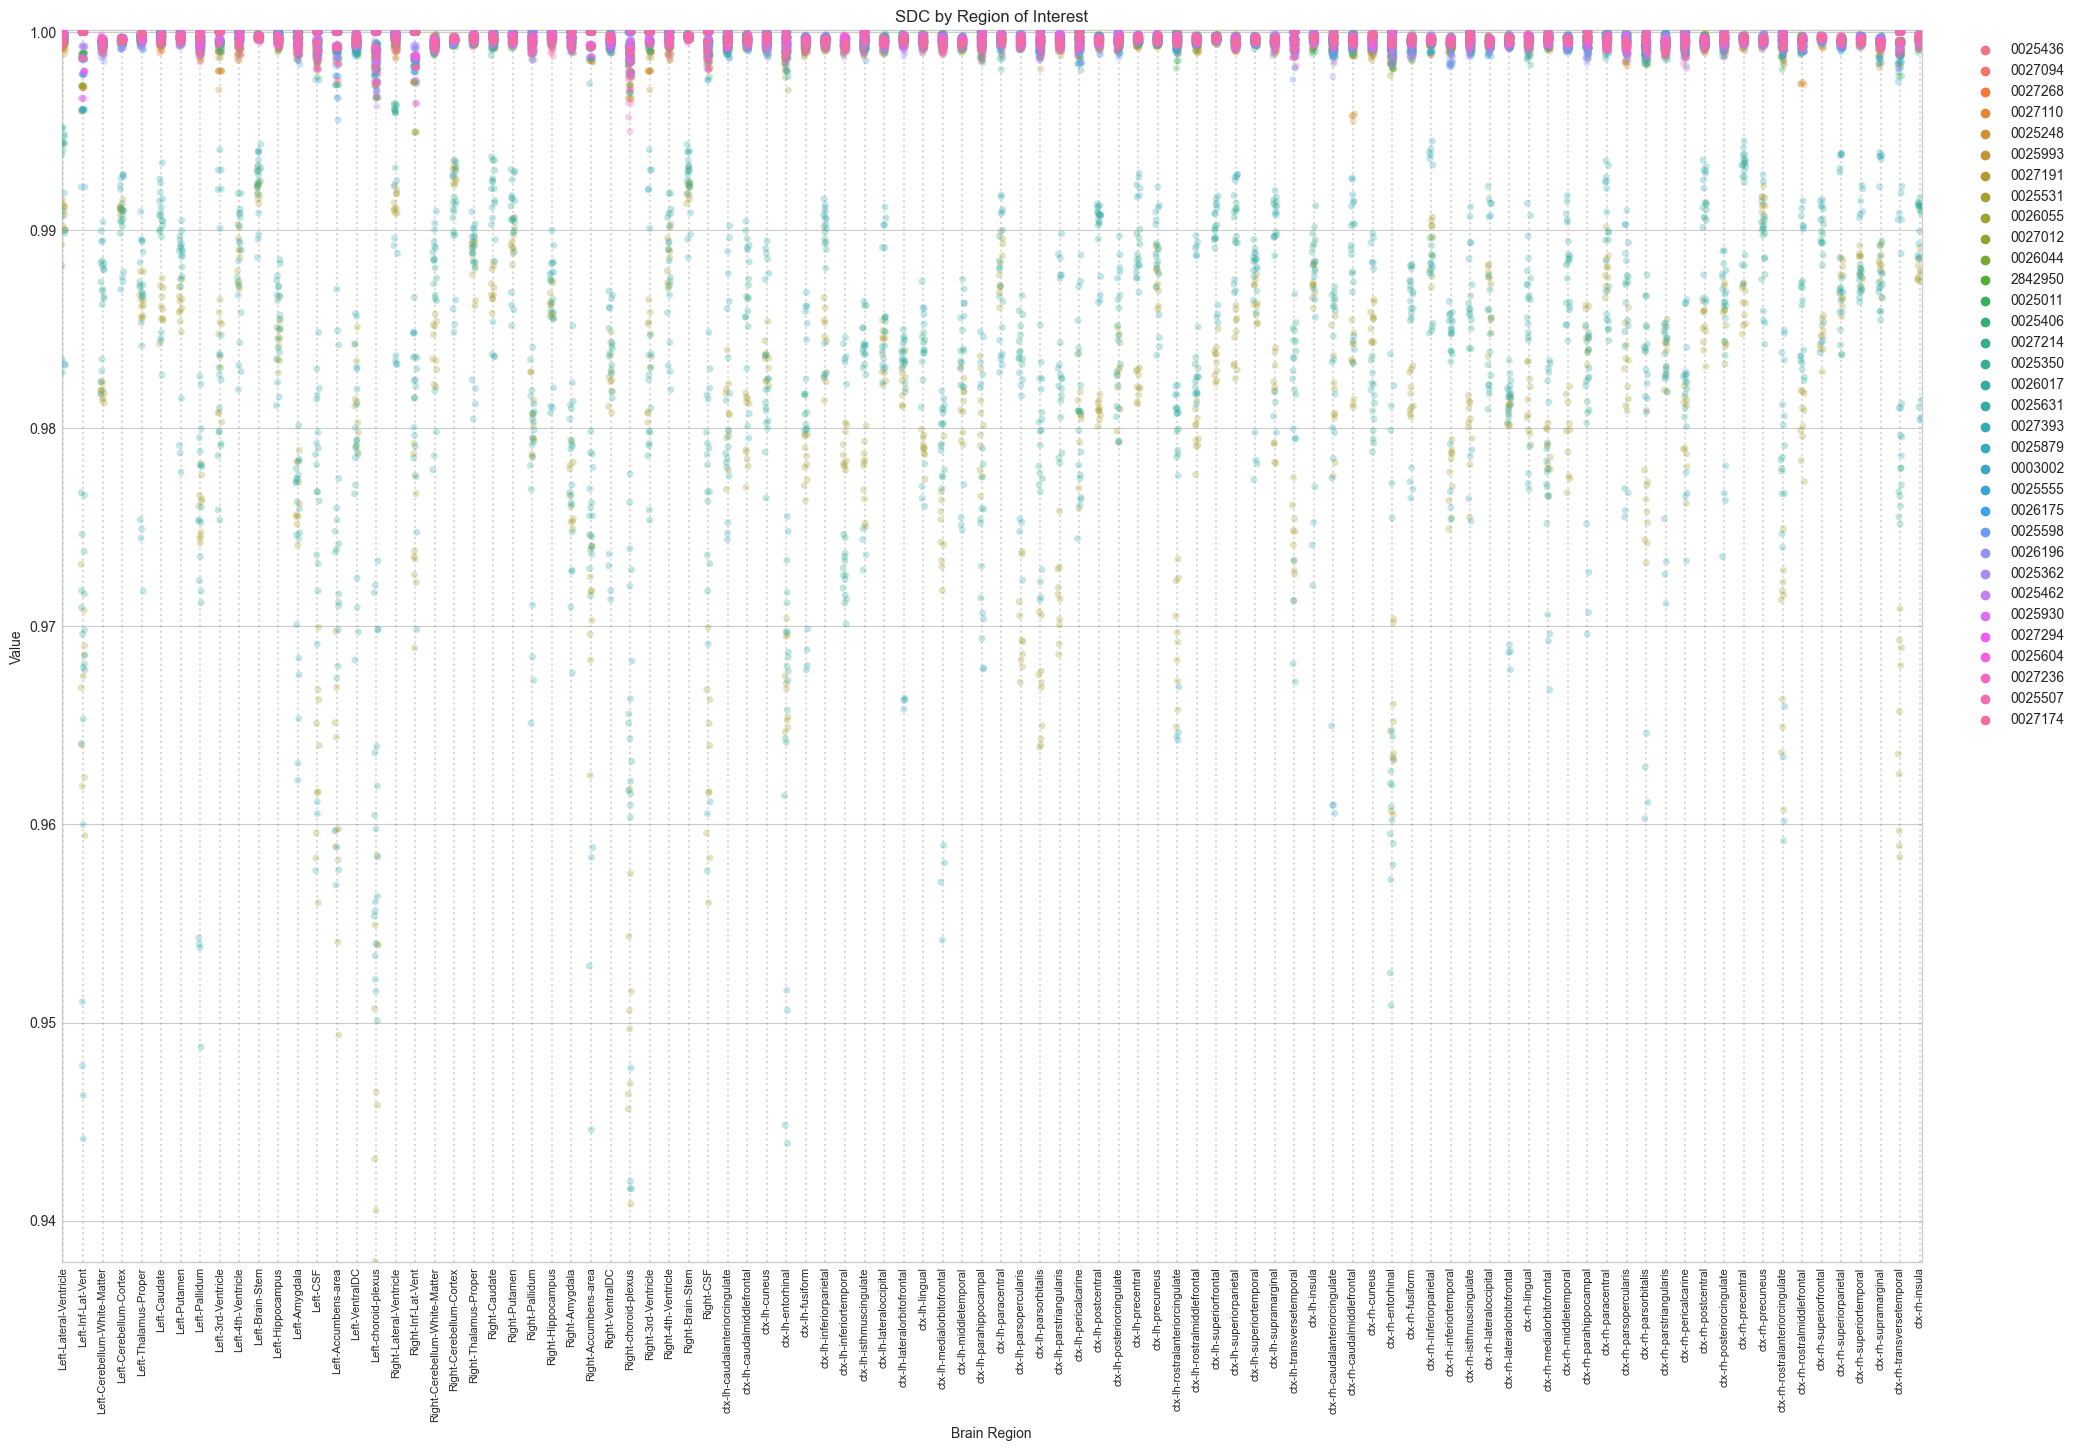

In [6]:
# import all necessary libraries required for outputting the visual support
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import numpy as np
import pandas as pd
import os

# List of all brain regions segmented by FastSurfer
regions = labels_lookup.keys()
region_arr = np.array(list(regions))
column_names = np.insert(region_arr,0,'subjectID')

# Replace the column names by appropriate brain regions
df_final = pd.read_csv('../Results/final_results.csv')
df_final.rename(columns=dict(zip(df_final.columns, column_names)), inplace=True)

# Sorting observations by subject IDs
df_final['subjectID'] = df_final['subjectID'].str.split('_').str[0]

# Specify the dataframe with the final results
data = df_final

# Get the subject IDs
subject_ids = data.iloc[:, 0]

# Transpose the DataFrame to have brain regions as columns
df_t = data.transpose()

# Reset the column names
df_t.columns = df_t.iloc[0]

# Drop the first row (original column names)
df_t = df_t.drop(df_t.index[0])

# Reset the index
df_t = df_t.reset_index()

# Melt the DataFrame to convert columns to rows
melted_df = pd.melt(df_t, id_vars='index', var_name='subjectID', value_name='Value')

# Set the figure size
plt.figure(figsize=(24, 16))  # Adjust width and height as desired

# Create the strip plot
sns.stripplot(x='index', y='Value', hue='subjectID', data=melted_df, alpha=0.3)

# Set plot title and labels
plt.title('SDC by Region of Interest')
plt.xlabel('Brain Region')
plt.ylabel('Value')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90, fontsize=8)
plt.margins(x=0, y=0)

# Adjust legend position
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

# Adjust the range of the y-axis
plt.ylim([0.9379, 1.0001]) 

# Adjust the x-axis to visually divide each brain region
x_values = melted_df['index'].unique()
for x in x_values:
    plt.vlines(x, melted_df['Value'].min(), melted_df['Value'].max(), linestyles='dotted', colors='gray', alpha=0.3)

# Display the plot
plt.show()

Due to the high number of datapoints - 95 datapoints for each of the 330 pairs - it is difficult to clearly overaly the box plot with the strip plot provided above. Thus, a separate Python code displays the box plot where we can better visualize the outliers.

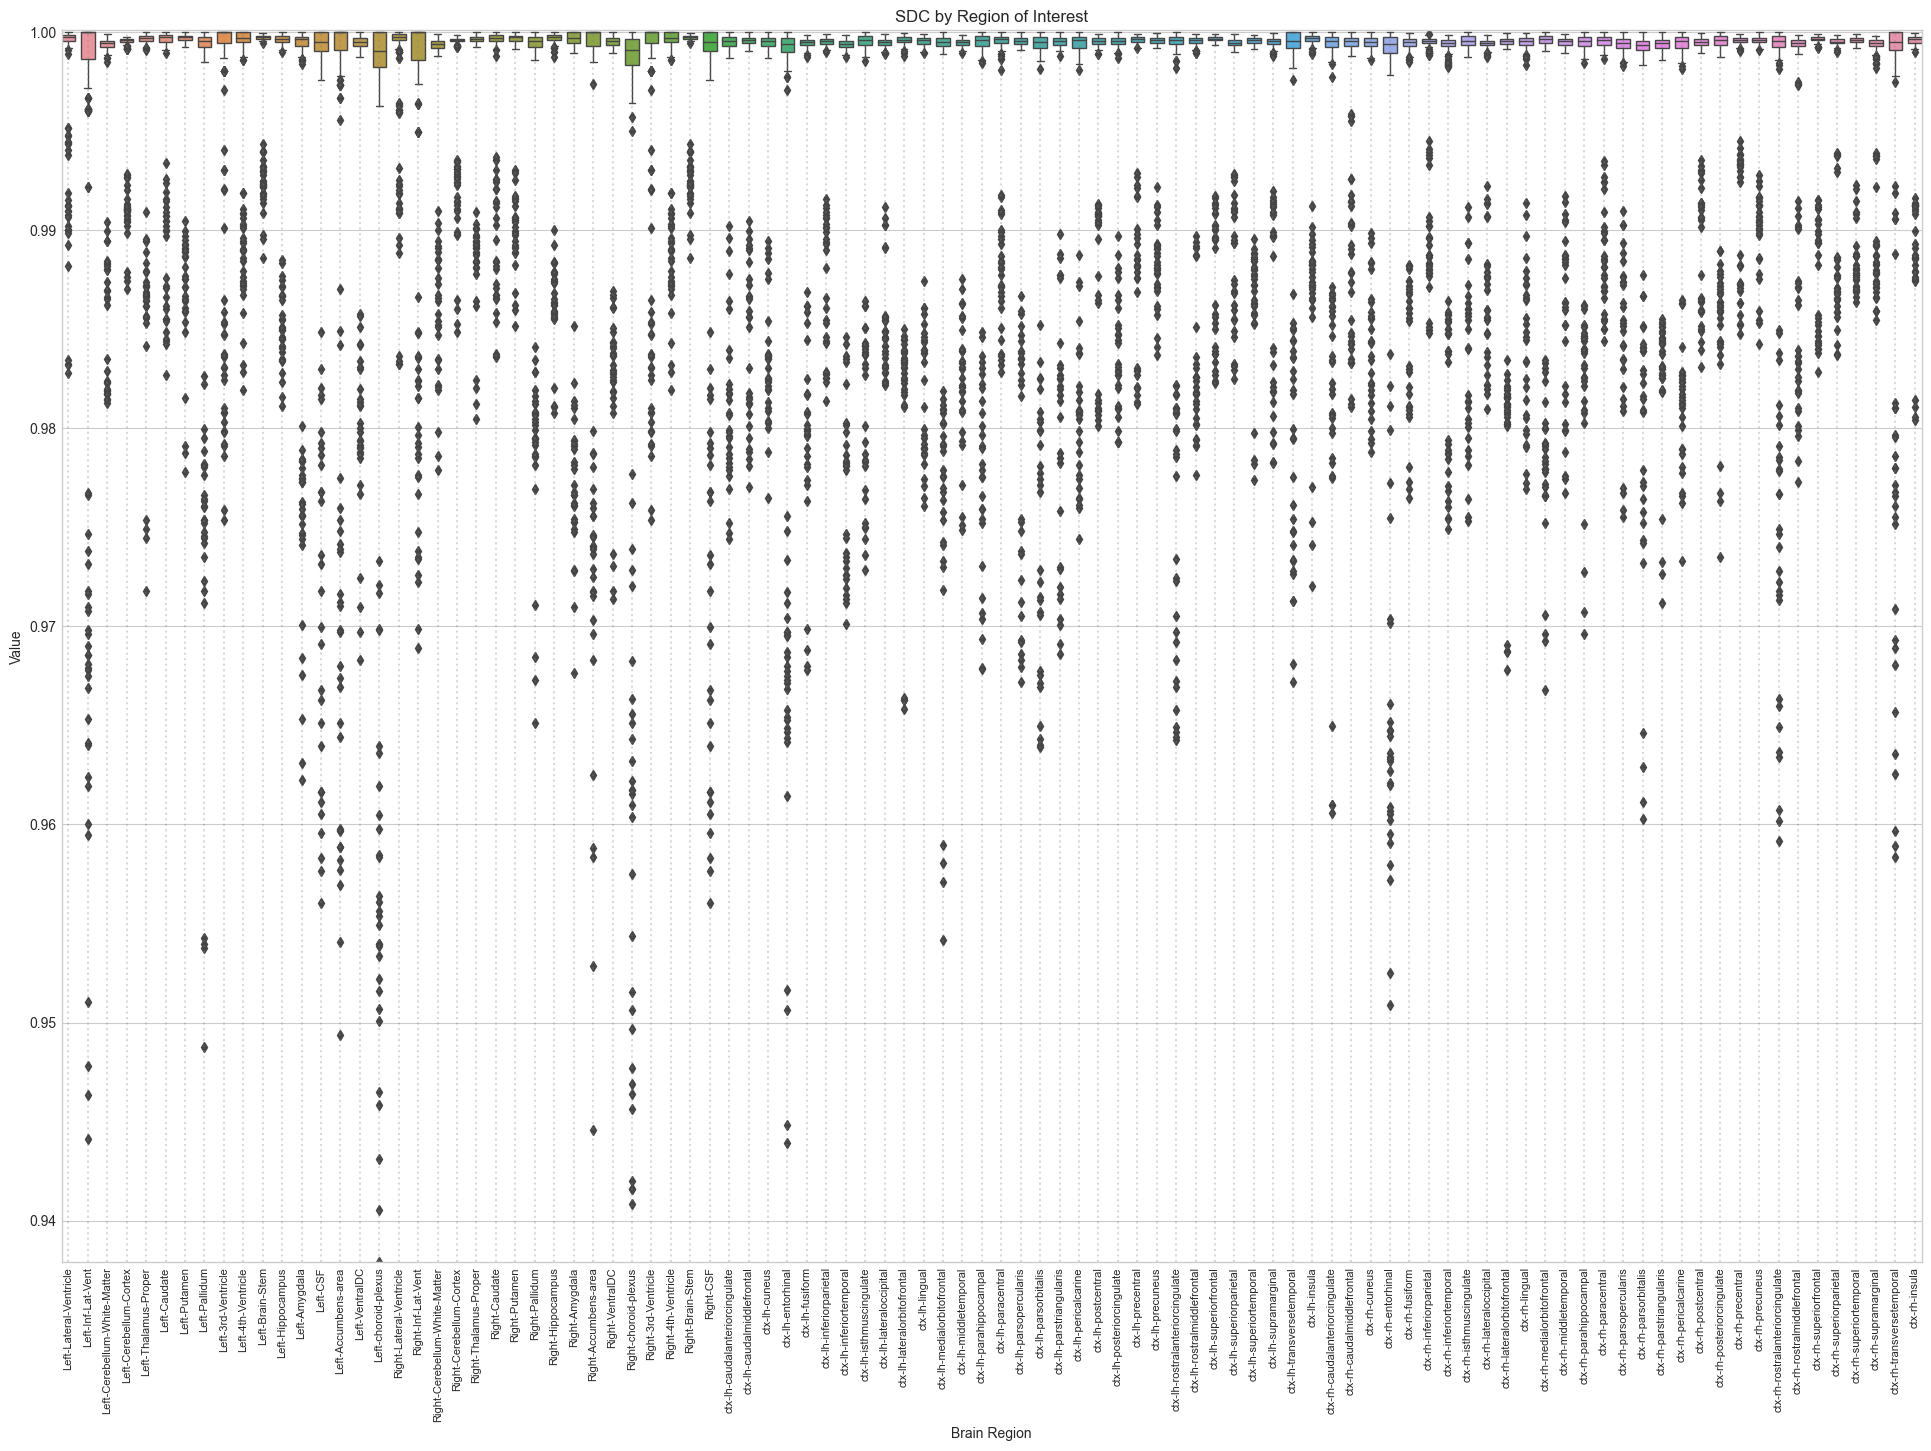

In [7]:
# Set the figure size
plt.figure(figsize=(24, 16))  # Adjust width and height as desired

# Define a color palette with different colors for each x value
color_palette = sns.color_palette('Set3', len(melted_df['index'].unique()))

# Create the box plot
sns.boxplot(x='index', y='Value', data=melted_df, width=0.7, linewidth=1)

# Set plot title and labels
plt.title('SDC by Region of Interest')
plt.xlabel('Brain Region')
plt.ylabel('Value')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90, fontsize=8)
plt.margins(x=0, y=0)

# Adjust the range of the y-axis
plt.ylim([0.9379, 1.0001]) 

# Adjust the x-axis to visually divide each brain region
x_values = melted_df['index'].unique()
for x in x_values:
    plt.vlines(x, melted_df['Value'].min(), melted_df['Value'].max(), linestyles='dotted', colors='gray', alpha=0.3)

# Display the plot
plt.show()

In [8]:
print('The maximum SDC value is ', df_final.iloc[:, 1:].to_numpy().max())
print('The minimum SDC value is ', df_final.iloc[:, 1:].to_numpy().min())

The maximum SDC value is  1.0
The minimum SDC value is  0.9379310344827586


Finally, a bar chart representing the variation in SDC values can be generated with the following Python code block. <br>



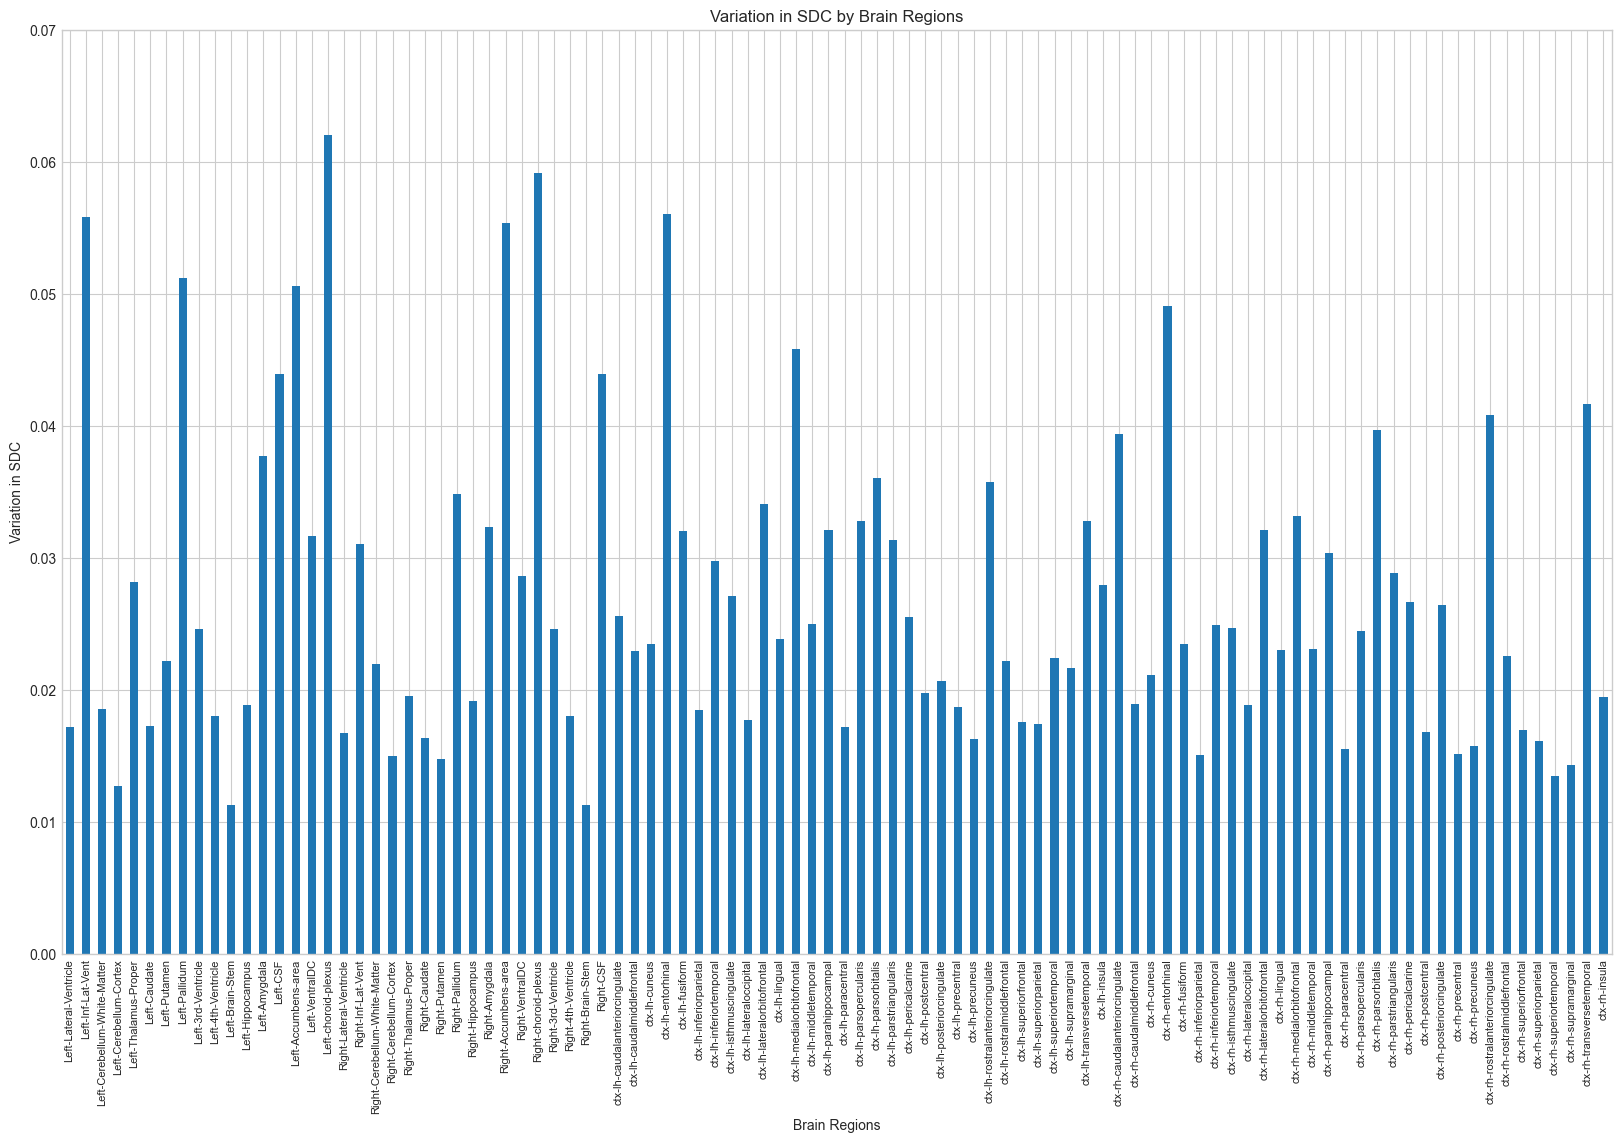

The brain region with the most variation in SDC is the Left-choroid-plexus  with the variation of  0.06206896551724139
The brain region with the least variation in SDC is the Left-Brain-Stem  with the variation of  0.011333669576954142
The average variation in SDC is  0.026971354210230915


In [9]:
# Set the figure size
plt.figure(figsize=(20, 12))  # Adjust width and height as desired

# determine the difference between the minimum and maximum value for each region
df_minmax = df_final.agg(['min', 'max']).iloc[:, 1:]
df_diff = df_minmax.diff()

# Plot a bar chart from the last row
diff = df_diff.iloc[-1]
diff.plot(kind='bar')

# Set plot title and labels
plt.title('Variation in SDC by Brain Regions')
plt.xlabel('Brain Regions')
plt.ylabel('Variation in SDC')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90, fontsize=8)
plt.margins(x=0, y=0)

# Adjust the range of the y-axis
plt.ylim([0, 0.07]) 

# Display the plot
plt.show()

print('The brain region with the most variation in SDC is the', df_diff.iloc[-1].idxmax(axis=0), ' with the variation of ', df_diff.iloc[-1].max())
print('The brain region with the least variation in SDC is the', df_diff.iloc[-1].idxmin(axis=0), ' with the variation of ', df_diff.iloc[-1].min())
print('The average variation in SDC is ', df_diff.iloc[-1].mean(axis=0))

### <b>4. Discussion and Conclusion</b>

In the plots of section 3.2, we can observe minimal variation in the segmentation results, as evidenced by the Sørensen-Dice Coefficient ranging from 0.9379310344827586 to 1.0. However, some variation did exist among different subjects, with some subjects showing less variation between different segmentation results. On average, however, the outcomes obtained from both the standard FastSurfer segmentation and the perturbed segmentation exhibit high similarity. Furthermore, the overall similarity across brain regions is notably high, with an average variation in the SDC value of 0.026971354210230915. The regions displaying the most significant variation in SDC value were the Left and Right Choroid Plexus, while the Left and Right Brain Stem exhibited the least variation. Consequently, the outcomes of this project support the argument that the CNN deep-learning model is highly reliable for image segmentation, and that FastSurfer's segmentation produces viable results. Nevertheless, there are possibility for enhancing this experiment to yield more insightful conclusions regarding the numerical stability of FastSurfer segmentation. Various factors could be considered, such as increasing the number of repetitions to execute FastSurfer with Verrou, incorporating other datasets encompassing a varied range of brain conditions, and comparing the segmentation performance with other similar deep-learning models and publicly available software.

### <b>I. References</b>

1. François Févotte, Bruno Lathuilière. VERROU: Assessing Floating-Point Accuracy Without Recompiling. 2016. hal-01383417f. https://hal.science/hal-01383417/document 

2. Henschel L, Conjeti S, Estrada S, Diers K, Fischl B, Reuter M, FastSurfer - A fast and accurate deep learning based neuroimaging pipeline, NeuroImage 219 (2020), 117012. https://doi.org/10.1016/j.neuroimage.2020.117012 

3.	Henschel L*, Kügler D*, Reuter M. (*co-first). FastSurferVINN: Building Resolution-Independence into Deep Learning Segmentation Methods - A Solution for HighRes Brain MRI. NeuroImage 251 (2022), 118933. http://dx.doi.org/10.1016/j.neuroimage.2022.118933

4. “Verrou: a floating-point rounding errors checker,” 12. Verrou: A floating-point rounding errors Checker, https://edf-hpc.github.io/verrou/vr-manual.html (accessed May 26, 2023). 
